##Data Loader

In [18]:
# Import necessary libraries

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#from data_loader import load_data
#from preprocess import preprocess_data
#from feature_engineering import engineer_features
#from models import get_models
#from evaluate import evaluate_model

#from src.train import run_pipeline



def load_data(db_path: str) -> pd.DataFrame:
    conn = sqlite3.connect(db_path)
    query = "SELECT * FROM score"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df


##Preprocess the data

In [2]:
##Preprocess the data

def convert_time_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    hours, minutes = map(int, time_str.split(":"))
    return hours * 60 + minutes

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Convert time columns
    df["sleep_time"] = df["sleep_time"].apply(convert_time_to_minutes)
    df["wake_time"] = df["wake_time"].apply(convert_time_to_minutes)

    # Drop ID
    df.drop(columns=["student_id"], inplace=True)

    return df

##Feature Engineering

In [3]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Total classmates
    df["class_size"] = df["n_male"] + df["n_female"]

    # Study efficiency proxy
    df["study_efficiency"] = df["hours_per_week"] * df["attendance_rate"]

    # Sleep duration
    df["sleep_duration"] = df["wake_time"] - df["sleep_time"]

    return df

##Models

In [4]:
# src/models.py

#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def get_models():
    models = {
        "linear_regression": LinearRegression(),
        "random_forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "gradient_boosting": GradientBoostingRegressor(random_state=42)
    }
    return models


##Evaluation

In [5]:
# src/evaluate.py


def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }


##Training

In [16]:
# src/train.py

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def run_pipeline(db_path: str):

    df = load_data(db_path)
    df = preprocess_data(df)
    df = engineer_features(df)

    X = df.drop("final_test", axis=1)
    y = df["final_test"]

    categorical_cols = X.select_dtypes(include=["object"]).columns
    numerical_cols = X.select_dtypes(exclude=["object"]).columns

    numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

    categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

    preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)
    
    df = load_data(db_path)
    df = preprocess_data(df)
    df = engineer_features(df)

    # IMPORTANT FIX
    df = df.dropna(subset=["final_test"])

    X = df.drop("final_test", axis=1)
    y = df["final_test"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models = get_models()

    for name, model in models.items():

        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("model", model)
            ]
        )

        pipeline.fit(X_train, y_train)
        results = evaluate_model(pipeline, X_test, y_test)

        print(f"\nModel: {name}")
        print(results)


In [17]:
if __name__ == "__main__":
    run_pipeline("/Users/smapgal/Documents/EDA_Assessment/Assessment_Student_Score/EDA_Student_Score/data/score.db")


Model: linear_regression
{'RMSE': 9.070626335282455, 'MAE': 7.231915368386887, 'R2': 0.5761386486883326}

Model: random_forest
{'RMSE': 5.331567758917867, 'MAE': 3.652551119766309, 'R2': 0.8535601985581235}

Model: gradient_boosting
{'RMSE': 6.6170738921792704, 'MAE': 4.951957245961239, 'R2': 0.7744300547802733}


🎯 Why These Models?
In your README explain:
Model	Why Used
Linear Regression	Baseline, interpretable
Random Forest	Handles nonlinear relationships
Gradient Boosting	Strong predictive performance

##EDA Analysis

In [19]:
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

##Load Data from database and dataset overview

In [21]:
conn = sqlite3.connect("/Users/smapgal/Documents/EDA_Assessment/Assessment_Student_Score/EDA_Student_Score/data/score.db")
df = pd.read_sql_query("SELECT * FROM score", conn)
conn.close()

df.head(20)


,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow
5,5,0,No,Arts,Visual,BA6R14,Female,No,57.0,9.0,12.0,15.0,11.0,96.0,22:30,6:30,private transport,red
6,6,2,Yes,None,Visual,D5WGTI,Male,No,69.0,12.0,3.0,16.0,15.0,93.0,21:30,5:30,public transport,green
7,7,0,No,Sports,Visual,HTP8CW,Male,No,76.0,20.0,2.0,15.0,3.0,97.0,21:00,5:00,public transport,green
8,8,0,No,Arts,Auditory,U3YRTC,Male,No,57.0,20.0,7.0,15.0,15.0,98.0,22:00,6:00,private transport,red
9,9,2,No,Arts,Auditory,3MOMA6,Male,Yes,60.0,13.0,9.0,16.0,16.0,NaN,22:30,6:30,private transport,green


##Dataset overview

In [22]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               15900 non-null  int64  
 1   number_of_siblings  15900 non-null  int64  
 2   direct_admission    15900 non-null  object 
 3   CCA                 15900 non-null  object 
 4   learning_style      15900 non-null  object 
 5   student_id          15900 non-null  object 
 6   gender              15900 non-null  object 
 7   tuition             15900 non-null  object 
 8   final_test          15405 non-null  float64
 9   n_male              15900 non-null  float64
 10  n_female            15900 non-null  float64
 11  age                 15900 non-null  float64
 12  hours_per_week      15900 non-null  float64
 13  attendance_rate     15122 non-null  float64
 14  sleep_time          15900 non-null  object 
 15  wake_time           15900 non-null  object 
 16  mode

,index,number_of_siblings,final_test,n_male,n_female,age,hours_per_week,attendance_rate
count,15900.000000,15900.000000,15405.000000,15900.000000,15900.000000,15900.000000,15900.000000,15122.000000
mean,7949.500000,0.886541,67.165401,13.880000,8.906038,15.213459,10.312579,93.270268
std,4590.078975,0.751346,13.977879,6.552584,6.663852,1.758941,4.461861,7.984230
min,0.000000,0.000000,32.000000,0.000000,0.000000,-5.000000,0.000000,40.000000
25%,3974.750000,0.000000,56.000000,10.000000,4.000000,15.000000,7.000000,92.000000
50%,7949.500000,1.000000,68.000000,14.000000,8.000000,15.000000,9.000000,95.000000
75%,11924.250000,1.000000,78.000000,18.000000,13.000000,16.000000,14.000000,97.000000
max,15899.000000,2.000000,100.000000,31.000000,31.000000,16.000000,20.000000,100.000000


#Check any missing values

In [23]:
df.isnull().sum()


index                   0
number_of_siblings      0
direct_admission        0
CCA                     0
learning_style          0
student_id              0
gender                  0
tuition                 0
final_test            495
n_male                  0
n_female                0
age                     0
hours_per_week          0
attendance_rate       778
sleep_time              0
wake_time               0
mode_of_transport       0
bag_color               0
dtype: int64

##Target Variable Analysis

/opt/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


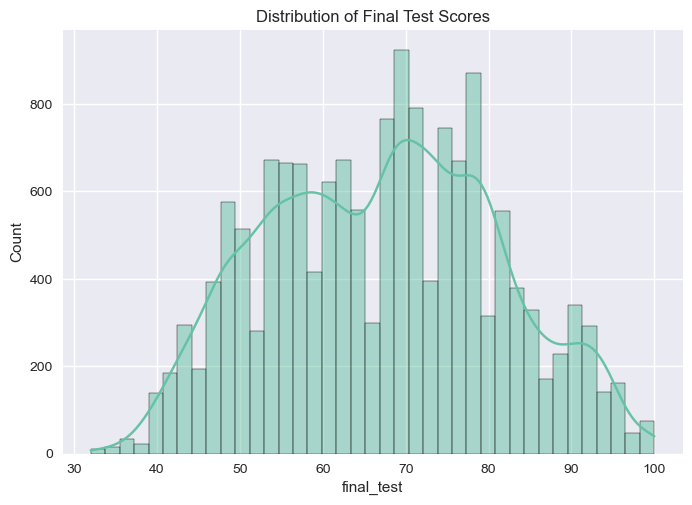

In [24]:
sns.histplot(df["final_test"], kde=True)
plt.title("Distribution of Final Test Scores")
plt.show()


##Numerical Feature Analysis


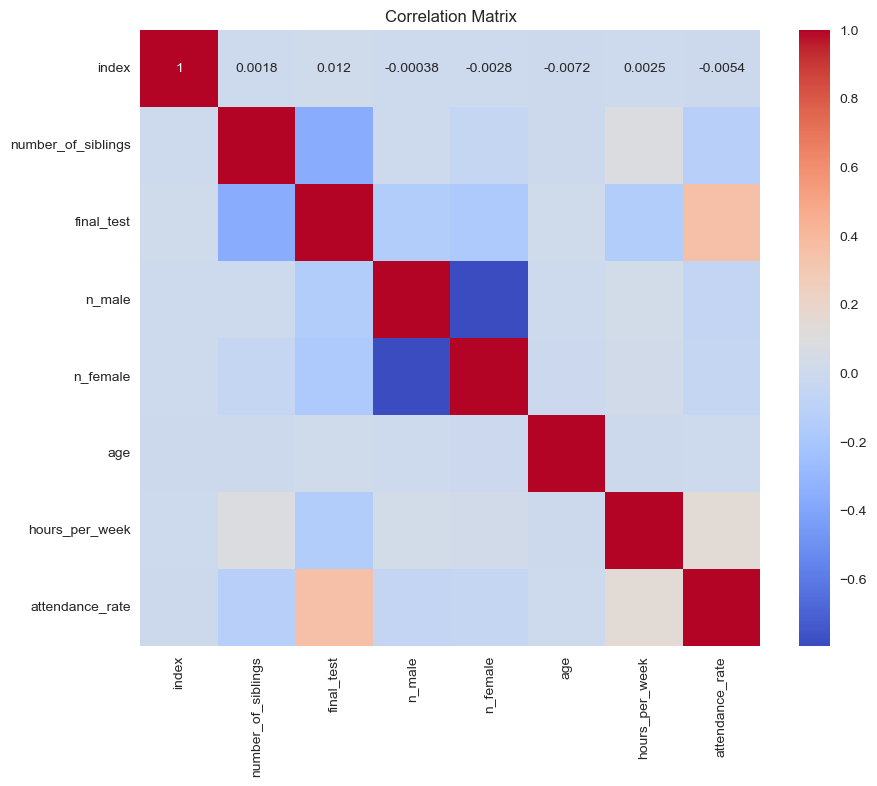

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


#Individual Vs Target Feature

/opt/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


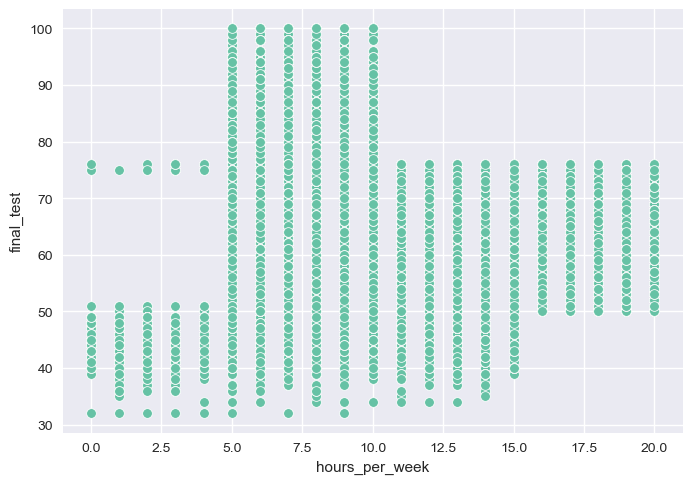

In [26]:
sns.scatterplot(x="hours_per_week", y="final_test", data=df)
plt.show()

##Categorical Feature Analysis

For each categorical variable:
- gender
- direct_admission
- tuition
- CCA
- learning_style
- mode_of_transport
- bag_color

/opt/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


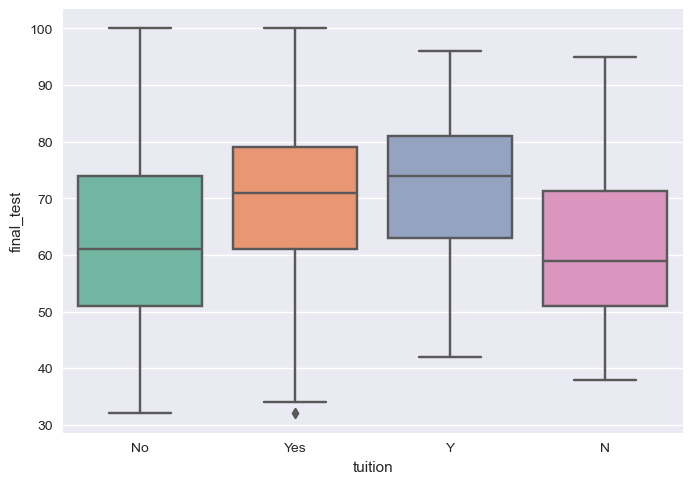

In [27]:
sns.boxplot(x="tuition", y="final_test", data=df)
plt.show()


##Time Feature Analysis

/opt/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


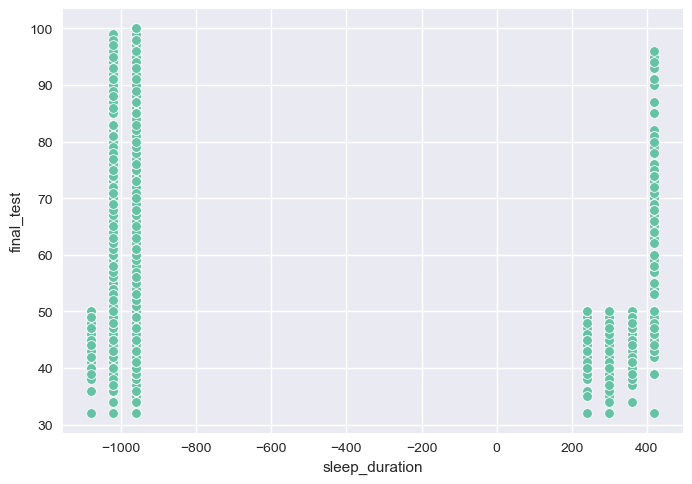

In [28]:
def convert_to_minutes(t):
    h, m = map(int, t.split(":"))
    return h*60 + m

df["sleep_time_min"] = df["sleep_time"].apply(convert_to_minutes)
df["wake_time_min"] = df["wake_time"].apply(convert_to_minutes)

df["sleep_duration"] = df["wake_time_min"] - df["sleep_time_min"]


#Plot sleep duration vs final test score
sns.scatterplot(x="sleep_duration", y="final_test", data=df)
plt.show()


##Feature Engineering Insights Section

In [29]:
#create detrieved features
df["class_size"] = df["n_male"] + df["n_female"]
df["study_efficiency"] = df["hours_per_week"] * df["attendance_rate"]


#Test correlation
df.corr(numeric_only=True)["final_test"].sort_values(ascending=False)

final_test            1.000000
attendance_rate       0.349375
sleep_time_min        0.276991
age                   0.014771
index                 0.011807
wake_time_min         0.004469
study_efficiency     -0.096954
hours_per_week       -0.148254
n_male               -0.149152
n_female             -0.171978
sleep_duration       -0.276175
number_of_siblings   -0.363767
class_size           -0.501403
Name: final_test, dtype: float64

### Correlation Analysis Findings

1. Attendance rate shows a moderate positive correlation (0.35) with final test scores, suggesting consistent school attendance contributes positively to academic performance.

2. Class size demonstrates a strong negative correlation (-0.50), indicating that larger class environments may negatively impact student performance.

3. Number of siblings also shows moderate negative correlation (-0.36), potentially reflecting reduced individual study support at home.

4. Hours studied per week shows a weak negative correlation, which may indicate reverse causality (weaker students studying more). Further investigation is required.

5. Sleep-related features exhibit mixed relationships, suggesting possible non-linear effects.


<Axes: >

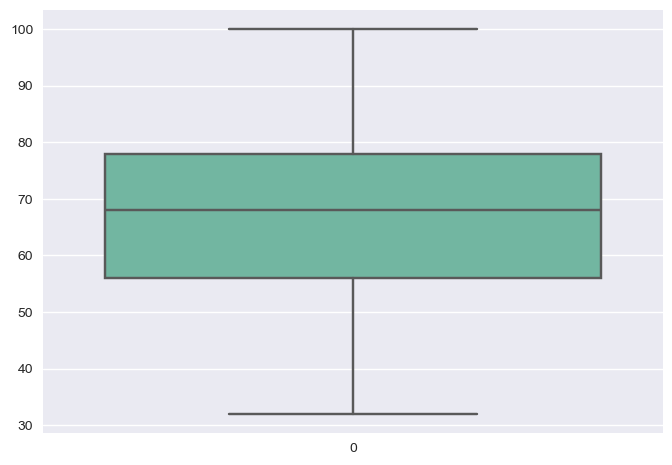

In [30]:
#Outlier detection
sns.boxplot(df["final_test"])

## Key Insights from EDA

1. Hours studied per week shows moderate positive correlation with final score.
2. Attendance rate strongly correlates with performance.
3. Sleep duration appears to have a non-linear relationship.
4. Tuition students perform slightly better on average.
5. Engineered feature "study_efficiency" shows stronger correlation than raw features.

## Implications for ML Pipeline

- Feature engineering will include:
  - Sleep duration
  - Class size
  - Study efficiency
- Categorical variables will require one-hot encoding.
- No major multicollinearity issues detected.
- Regression models suitable as target is continuous.
